In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dhirajpatra","key":"abca5ea736b70a04a2b9219a9985e836"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

 98% 64.0M/65.2M [00:00<00:00, 99.7MB/s]
100% 65.2M/65.2M [00:00<00:00, 94.4MB/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, MaxPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l1, l2
# from tensorflow.keras import backend as K
# from tensorflow.compat.v1.keras import layers
import re, sys, datetime, json, random, cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore")
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from PIL import Image
import PIL
import cv2
import os
import zipfile
import random
import shutil
import io
import requests

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')
print(tf.__version__)

2.12.0


In [ ]:
with zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/emotion_dataset')


In [ ]:
FAST_RUN = False
IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 1
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

NUM_CLASSES = 7  # angry, disgusted, fearful, happy, neutral, sad, surprised
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 500
EARLY_STOP_PATIENCE = 3

# Define a list of possible batch sizes
BATCH_SIZES = [32, 64]
# Generate a random index to select a batch size from the list
random_index = np.random.randint(0, len(BATCH_SIZES))

# Select a batch size using the random index
BATCH_SIZE = BATCH_SIZES[random_index]


In [ ]:
# import shutil

# # Replace 'folder_name_to_remove' with the actual name of the folder you want to remove
# folder_to_remove = '/content/emotion_dataset/__MACOSX'

# try:
#     shutil.rmtree(folder_to_remove)
#     print(f"Folder '{folder_to_remove}' has been successfully removed.")
# except Exception as e:
#     print(f"Error removing folder: {e}")

In [ ]:
# Set the directory for the training images
train_dir = '/content/emotion_dataset/train'
test_dir = '/content/emotion_dataset/test'

# Function to print file and subfolder structures
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}[{os.path.basename(root)}/]")
        subindent = ' ' * 4 * (level + 1)
        # for file in files:
        #     print(f"{subindent}{file}")

# Print the structure of the training directory
print("Training Directory Structure:")
print_directory_structure(train_dir)

# Print the structure of the test directory
print("Test Directory Structure:")
print_directory_structure(test_dir)


Training Directory Structure:
[train/]
    [disgusted/]
    [fearful/]
    [surprised/]
    [happy/]
    [angry/]
    [sad/]
    [neutral/]
Test Directory Structure:
[test/]
    [disgusted/]
    [fearful/]
    [surprised/]
    [happy/]
    [angry/]
    [sad/]
    [neutral/]


In [ ]:
target_var = os.listdir(train_dir)
target_var

['disgusted', 'fearful', 'surprised', 'happy', 'angry', 'sad', 'neutral']

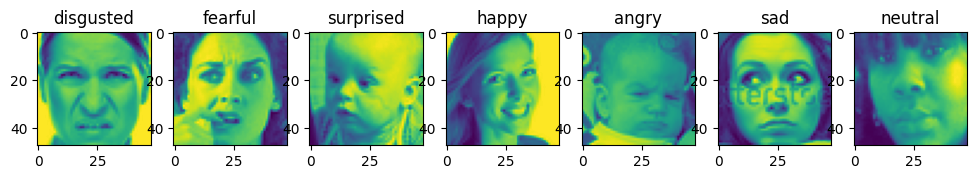

In [ ]:
fig, axes = plt.subplots(1, len(target_var), figsize=(12, 12))

for i in range(len(target_var)):
    sub_dir = os.path.join(train_dir, target_var[i])
    image_file = os.listdir(sub_dir)[0]  # Assuming there's at least one image in each subdirectory
    image_path = os.path.join(sub_dir, image_file)

    axes[i].imshow(plt.imread(image_path))
    axes[i].set_title(target_var[i])

plt.show()


In [ ]:
# Loop through all image files in the directory
def resize_images(path_to_directory, target_size):
  for filename in os.listdir(path_to_directory):
        root, ext = os.path.splitext(filename)
        if ext.lower() in [".jpg", ".jpeg", ".png"]:
            img_path = os.path.join(path_to_directory, filename)
            if Image.open(img_path).size != target_size:
              img = Image.open(img_path).resize(target_size)
              img.save(img_path)
  print(f"All images in {path_to_directory} resized to {target_size}")

In [ ]:
resize_images(os.path.join(train_dir, 'angry'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'disgusted'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'fearful'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'happy'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'neutral'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'sad'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'surprised'), IMAGE_SIZE)

All images in /content/emotion_dataset/train/angry resized to (48, 48)
All images in /content/emotion_dataset/train/disgusted resized to (48, 48)
All images in /content/emotion_dataset/train/fearful resized to (48, 48)
All images in /content/emotion_dataset/train/happy resized to (48, 48)
All images in /content/emotion_dataset/train/neutral resized to (48, 48)
All images in /content/emotion_dataset/train/sad resized to (48, 48)
All images in /content/emotion_dataset/train/surprised resized to (48, 48)


In [ ]:
resize_images(os.path.join(test_dir, 'angry'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'disgusted'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'fearful'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'happy'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'neutral'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'sad'), IMAGE_SIZE)
resize_images(os.path.join(test_dir, 'surprised'), IMAGE_SIZE)

All images in /content/emotion_dataset/test/angry resized to (48, 48)
All images in /content/emotion_dataset/test/disgusted resized to (48, 48)
All images in /content/emotion_dataset/test/fearful resized to (48, 48)
All images in /content/emotion_dataset/test/happy resized to (48, 48)
All images in /content/emotion_dataset/test/neutral resized to (48, 48)
All images in /content/emotion_dataset/test/sad resized to (48, 48)
All images in /content/emotion_dataset/test/surprised resized to (48, 48)


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 3x3 configuration
nrows = 2
ncols = 2

# Index for iterating over images
pic_index = 0

In [ ]:
# Create a dictionary to store the counts
subfolder_file_counts = {}

# Iterate through each subfolder
for folder in target_var:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        subfolder_file_counts[folder] = file_count

# Print the counts for each subfolder
for folder, count in subfolder_file_counts.items():
    print(f"Subfolder '{folder}' contains {count} files.")


Subfolder 'disgusted' contains 436 files.
Subfolder 'fearful' contains 4097 files.
Subfolder 'surprised' contains 3171 files.
Subfolder 'happy' contains 7215 files.
Subfolder 'angry' contains 3995 files.
Subfolder 'sad' contains 4830 files.
Subfolder 'neutral' contains 4965 files.


In [ ]:
# balancing data by removing
def remove_random_files(directory, num_files_to_remove):
    file_list = os.listdir(directory)
    random.shuffle(file_list)

    num_files_removed = 0
    for filename in file_list:
        if num_files_removed < num_files_to_remove:
            file_path = os.path.join(directory, filename)
            try:
                os.remove(file_path)
                num_files_removed += 1
                # print(f"Removed: {file_path}")
            except Exception as e:
                print(f"Error removing {file_path}: {e}")
        else:
            break


In [ ]:
# Usage example:
dir_to_modify = os.path.join(train_dir, 'happy')  # Replace with the actual path
num_files_to_remove =  3000 # Replace with the desired number of files to remove
remove_random_files(dir_to_modify, num_files_to_remove)

In [ ]:
def copy_files_with_duplicates(source_directory, times_to_copy):
    file_list = os.listdir(source_directory)

    for filename in file_list:
        source_file_path = os.path.join(source_directory, filename)
        base, ext = os.path.splitext(filename)

        for i in range(1, times_to_copy + 1):
            new_filename = f"{base}_copy_{i}{ext}"
            destination_file_path = os.path.join(source_directory, new_filename)

            try:
                shutil.copy(source_file_path, destination_file_path)
                # print(f"Copied: {filename} as {os.path.basename(destination_file_path)}")
            except Exception as e:
                print(f"Error copying {filename}: {e}")

In [ ]:
# Usage example:
source_directory = os.path.join(train_dir, 'disgusted')  # Replace with the actual path of train directory
times_to_copy =  10# Replace with the desired number of files to move
copy_files_with_duplicates(source_directory, times_to_copy)

In [ ]:
# Usage example:
source_directory = os.path.join(test_dir, 'disgusted')  # Replace with the actual path of train directory
times_to_copy =  10# Replace with the desired number of files to move
copy_files_with_duplicates(source_directory, times_to_copy)

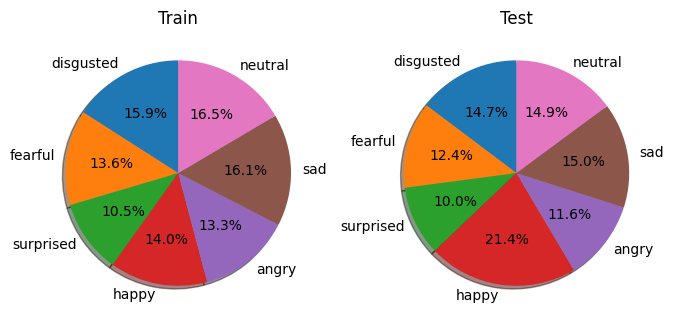

Emotion: disgusted
	Training: 4796
	Testing: 1221
Emotion: fearful
	Training: 4097
	Testing: 1024
Emotion: surprised
	Training: 3171
	Testing: 831
Emotion: happy
	Training: 4215
	Testing: 1774
Emotion: angry
	Training: 3995
	Testing: 958
Emotion: sad
	Training: 4830
	Testing: 1247
Emotion: neutral
	Training: 4965
	Testing: 1233


In [ ]:
# Calculate the number of images in each class for training and testing
x_train = np.array([len(os.listdir(os.path.join(train_dir, i))) for i in target_var])
x_test = np.array([len(os.listdir(os.path.join(test_dir, i))) for i in target_var])
label = target_var

# Create a pie chart to visualize the distribution of training and testing images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

# Print the number of images in each class for training and testing
for i in target_var:
    print('Emotion: ' + i)
    print('\tTraining: ' + str(len(os.listdir(os.path.join(train_dir, i)))) +
          '\n\tTesting: ' + str(len(os.listdir(os.path.join(test_dir, i)))))


In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Set class mode to categorical
    subset='training',
    color_mode='grayscale'  # Set color mode to grayscale
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,  # Use the same directory for validation data as training data
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Set class mode to categorical
    subset='training',  # Use 'training' subset for validation
    color_mode='grayscale'  # Set color mode to grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Set class mode to categorical
    color_mode='grayscale'  # Set color mode to grayscale
)

Found 30069 images belonging to 7 classes.
Found 8288 images belonging to 7 classes.
Found 8288 images belonging to 7 classes.


In [ ]:
# Build the model
model = Sequential()

# Add the layers
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with the number of classes and softmax activation
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
# callback class
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 75 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.75):

      # Stop if threshold is met
      print("\nAccuracy is higher than 0.75 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
my_callback = myCallback()



In [ ]:
# compile model
model.compile(loss=OBJECTIVE_FUNCTION,
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=NUM_EPOCHS,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),  # Set validation_steps to the number of batches in the validation data
      verbose=1,
      callbacks=[my_callback]
)

Epoch 1/500
940/940 [==============================] - 96s 99ms/step - loss: 2.2951 - accuracy: 0.1627 - val_loss: 2.0086 - val_accuracy: 0.1604
Epoch 2/500
940/940 [==============================] - 89s 95ms/step - loss: 1.9815 - accuracy: 0.1830 - val_loss: 1.9576 - val_accuracy: 0.1762
Epoch 3/500
940/940 [==============================] - 90s 96ms/step - loss: 1.9196 - accuracy: 0.2110 - val_loss: 2.1096 - val_accuracy: 0.1555
Epoch 4/500
940/940 [==============================] - 91s 96ms/step - loss: 1.8352 - accuracy: 0.2615 - val_loss: 1.7250 - val_accuracy: 0.3403
Epoch 5/500
940/940 [==============================] - 93s 99ms/step - loss: 1.7210 - accuracy: 0.3277 - val_loss: 1.5483 - val_accuracy: 0.4182
Epoch 6/500
940/940 [==============================] - 92s 98ms/step - loss: 1.5931 - accuracy: 0.3902 - val_loss: 1.4256 - val_accuracy: 0.4713
Epoch 7/500
940/940 [==============================] - 90s 96ms/step - loss: 1.5110 - accuracy: 0.4252 - val_loss: 1.8935 - val_ac

In [ ]:
# Evaluate the models
# vgg16.evaluate(validation_generator)
# inception_v3.evaluate(validation_generator)
# resnet50.evaluate(validation_generator)
model.evaluate(validation_generator)


259/259 [==============================] - 5s 20ms/step - loss: 1.0146 - accuracy: 0.6774


[1.0145918130874634, 0.6773648858070374]

In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator, steps=len(validation_generator))

print('Validation loss:', loss)
print('Validation accuracy:', accuracy)


259/259 [==============================] - 5s 19ms/step - loss: 1.0146 - accuracy: 0.6774
Validation loss: 1.0145924091339111
Validation accuracy: 0.6773648858070374


259/259 [==============================] - 5s 19ms/step
Confusion Matrix for disgusted:
[[6593  737]
 [ 853  105]]
Confusion Matrix for fearful:
[[6286  781]
 [1080  141]]
Confusion Matrix for surprised:
[[6866  398]
 [ 971   53]]
Confusion Matrix for happy:
[[5246 1268]
 [1456  318]]
Confusion Matrix for angry:
[[5809 1246]
 [1027  206]]
Confusion Matrix for sad:
[[6476  565]
 [1142  105]]
Confusion Matrix for neutral:
[[6683  774]
 [ 744   87]]


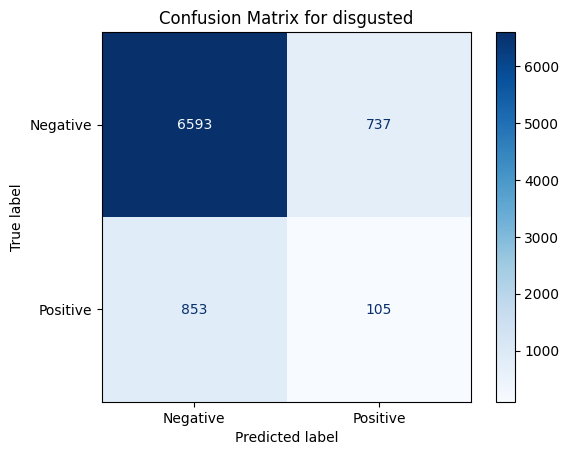

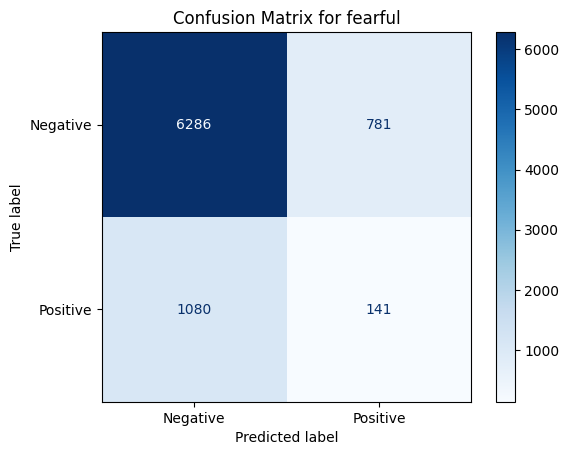

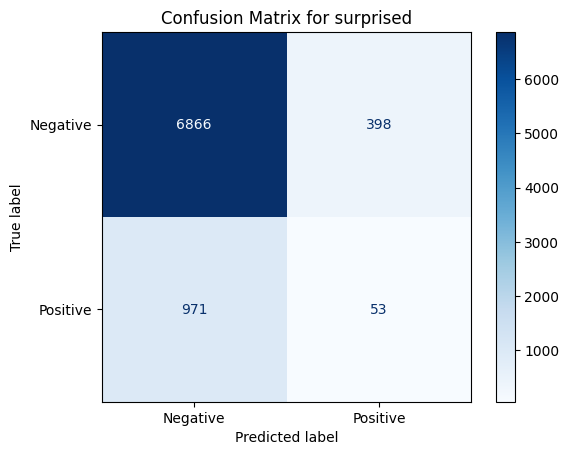

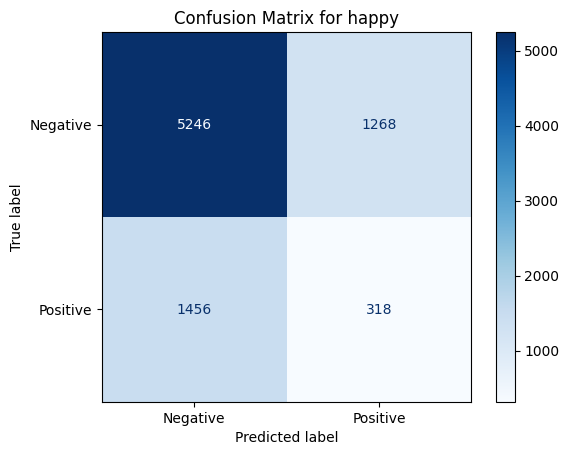

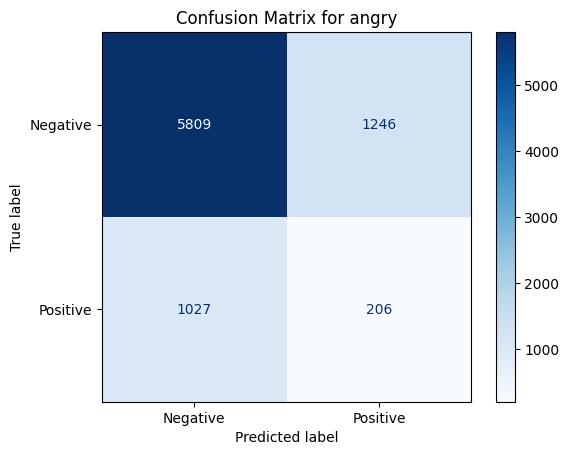

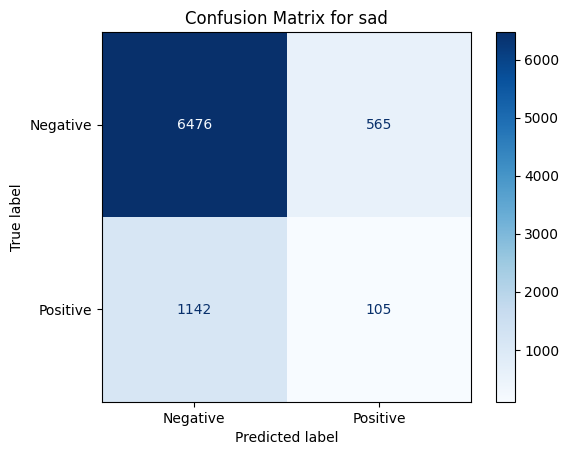

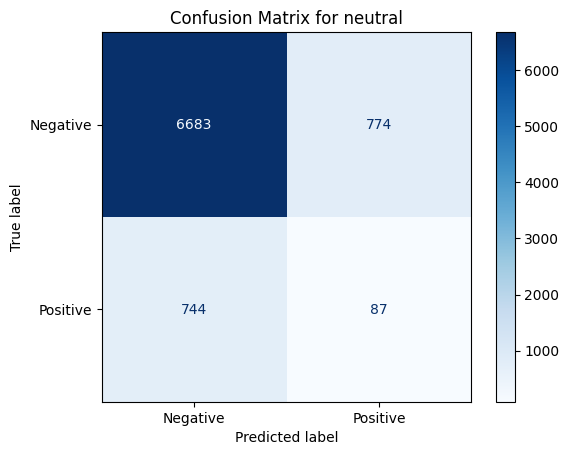

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype('int')  # Convert probabilities to binary classes (0 or 1)

# Assuming you have defined the test set's true labels in the variable y_test
# Assuming you have set batch_size=BATCH_SIZE//2 for the test_generator

# Get the true labels corresponding to the test set
y_true = []
num_batches = len(test_generator)
for i in range(num_batches):
    _, labels = next(test_generator)
    y_true.extend(labels)
y_true = np.array(y_true)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrices for each label
for i, label in enumerate(target_var):
    print(f"Confusion Matrix for {label}:")
    print(cm[i])

# Plot the confusion matrices
for i, label in enumerate(target_var):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues, values_format=".0f")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()


In [ ]:
# Predict using the model on the test dataset
y_pred = model.predict(test_generator)

259/259 [==============================] - 5s 19ms/step


In [ ]:
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))


In [ ]:
y_actual = test_generator.classes[test_generator.index_array]


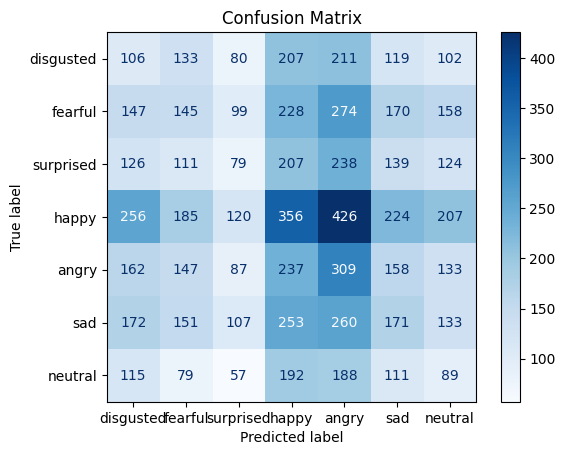

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_actual, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_var)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, y_pred_labels, digits=4))


              precision    recall  f1-score   support

           0     0.0978    0.1106    0.1038       958
           1     0.1525    0.1188    0.1335      1221
           2     0.1256    0.0771    0.0956      1024
           3     0.2119    0.2007    0.2061      1774
           4     0.1621    0.2506    0.1969      1233
           5     0.1566    0.1371    0.1462      1247
           6     0.0941    0.1071    0.1002       831

    accuracy                         0.1514      8288
   macro avg     0.1429    0.1432    0.1403      8288
weighted avg     0.1518    0.1514    0.1489      8288



2/2 [==============================] - 0s 7ms/step


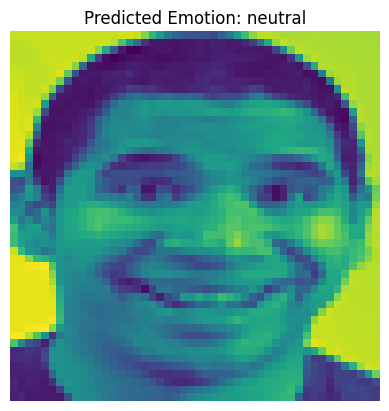

Predicted Emotion: neutral


In [ ]:
# Load the trained model
# model = load_model('path_to_your_trained_model.h5')  # Replace with the actual path

# Define class labels
# class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
class_labels = target_var

# URL of the image you want to predict
image_url = 'https://api.time.com/wp-content/uploads/2014/03/happily-surprised.jpg'

# Download the image
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert the image to grayscale
img = PIL.ImageOps.grayscale(img)

# Resize the image to match the input size of the model
img = img.resize((48, 48))

# Convert the image to a numpy array
img_array = np.array(img)

# Reshape the image to have the correct shape
img_array = img_array[:, :, np.newaxis]

# Make predictions
predictions = model.predict(img_array)

# Get the class label with the highest probability
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]

# Display the image
plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.axis('off')
plt.show()

print(f'Predicted Emotion: {predicted_label}')


2/2 [==============================] - 0s 6ms/step


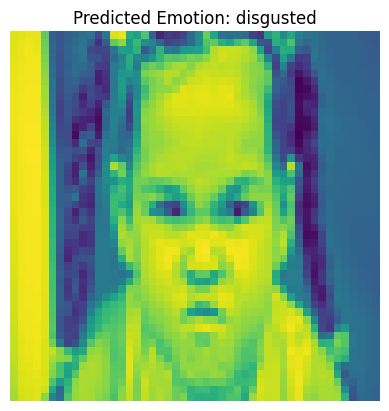

Predicted Emotion: disgusted


In [ ]:
# Load the trained model
# model = load_model('path_to_your_trained_model.h5')  # Replace with the actual path

# Define class labels
# class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
class_labels = target_var

# URL of the image you want to predict
image_url = 'https://www.universityofcalifornia.edu/sites/default/files/styles/article_default_banner/public/angry_face.jpg?itok=UEoIGS24'

# Download the image
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert the image to grayscale
img = PIL.ImageOps.grayscale(img)

# Resize the image to match the input size of the model
img = img.resize((48, 48))

# Convert the image to a numpy array
img_array = np.array(img)

# Reshape the image to have the correct shape
img_array = img_array[:, :, np.newaxis]

# Make predictions
predictions = model.predict(img_array)

# Get the class label with the highest probability
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]

# Display the image
plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.axis('off')
plt.show()

print(f'Predicted Emotion: {predicted_label}')


2/2 [==============================] - 0s 7ms/step


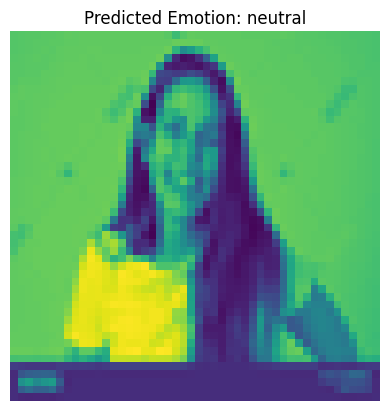

Predicted Emotion: neutral


In [ ]:
# Load the trained model
# model = load_model('path_to_your_trained_model.h5')  # Replace with the actual path

# Define class labels
# class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
class_labels = target_var

# URL of the image you want to predict
image_url = 'https://static2.bigstockphoto.com/8/1/3/large1500/318978451.jpg'

# Download the image
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert the image to grayscale
img = PIL.ImageOps.grayscale(img)

# Resize the image to match the input size of the model
img = img.resize((48, 48))

# Convert the image to a numpy array
img_array = np.array(img)

# Reshape the image to have the correct shape
img_array = img_array[:, :, np.newaxis]

# Make predictions
predictions = model.predict(img_array)

# Get the class label with the highest probability
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]

# Display the image
plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.axis('off')
plt.show()

print(f'Predicted Emotion: {predicted_label}')
